# Modeling the Heston stochastic differential model for price with a SDE_NN

The script aims to train a neural network to mimic the terminal distribution of the Heston stochastic volatility model. It does this by minimizing the Wasserstein distance between the terminal asset prices generated by the Heston model and those generated by a neural network-parameterized SDE (SDE-NN).

**Heston Model SDEs:**

The Heston model defines the asset price $S_t$ and its variance $v_t$ through the following system of stochastic differential equations:

$$
\begin{aligned}
dS_t &= r S_t dt + \sqrt{v_t} S_t dW_t \\
dv_t &= \kappa (\theta - v_t) dt + \sigma \sqrt{v_t} dZ_t
\end{aligned}
$$

where $W_t$ and $Z_t$ are Brownian motions with correlation $\rho$. The `simulate_heston` function implements a discrete-time (Euler) approximation of these equations.

**SDE-NN:**

The SDE-NN attempts to learn drift and diffusion functions directly from data. In this initial version, the learned SDE for the asset price $X_t$ (represented by the network's output) is implicitly defined through the neural network's output:

$$
dX_t = \mu(X_t, W'_t, t; \theta) dt + \sigma(X_t, W'_t, t; \theta) dW'_t
$$

Here, $\mu$ and $\sigma$ are the drift and diffusion coefficients parameterized by the neural network (with weights $\theta$), and $W'_t$ is a standard Brownian motion. The `SDENN` network takes the current asset price (`x`), a noise sample (`noise`), and time (`t`) as input and outputs two values that are used to determine the change in the asset price ($\Delta x$) over a small time step in the `generate_sdenn_paths` function:

$$
\Delta x = \text{drift\_output} \cdot \Delta t + \text{diffusion\_output} \cdot \sqrt{\Delta t} \cdot \text{noise}
$$

The neural network learns the functional forms of the drift and diffusion implicitly by trying to match the terminal distribution of the Heston model. This initial SDE-NN does not explicitly model a second stochastic factor like the variance in the Heston model.

Epoch 0, Wasserstein Loss: 14.3706
Epoch 1, Wasserstein Loss: 14.1900
Epoch 2, Wasserstein Loss: 14.0154
Epoch 3, Wasserstein Loss: 13.8306
Epoch 4, Wasserstein Loss: 13.6583
Epoch 5, Wasserstein Loss: 13.4772
Epoch 6, Wasserstein Loss: 13.3047
Epoch 7, Wasserstein Loss: 13.1214
Epoch 8, Wasserstein Loss: 12.9880
Epoch 9, Wasserstein Loss: 12.8129
Epoch 10, Wasserstein Loss: 12.6681
Epoch 11, Wasserstein Loss: 12.5431
Epoch 12, Wasserstein Loss: 12.4094
Epoch 13, Wasserstein Loss: 12.2536
Epoch 14, Wasserstein Loss: 12.0888
Epoch 15, Wasserstein Loss: 11.9653
Epoch 16, Wasserstein Loss: 11.8529
Epoch 17, Wasserstein Loss: 11.7392
Epoch 18, Wasserstein Loss: 11.6582
Epoch 19, Wasserstein Loss: 11.4721
Epoch 20, Wasserstein Loss: 11.4190
Epoch 21, Wasserstein Loss: 11.3131
Epoch 22, Wasserstein Loss: 11.1609
Epoch 23, Wasserstein Loss: 11.0406
Epoch 24, Wasserstein Loss: 10.9429
Epoch 25, Wasserstein Loss: 10.8755
Epoch 26, Wasserstein Loss: 10.7618
Epoch 27, Wasserstein Loss: 10.7445
Ep

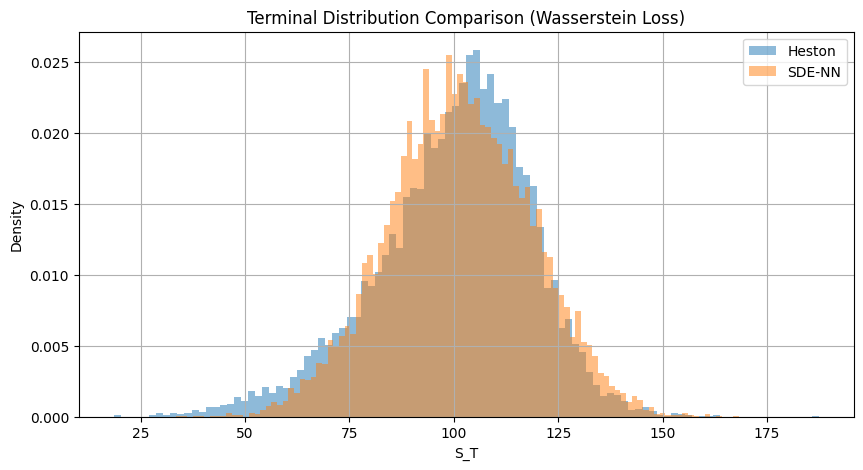

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Heston Model Simulator
def simulate_heston(S0, v0, r, kappa, theta, sigma, rho, T, N, M):
    dt = T / N
    S = torch.zeros(M, N + 1)
    v = torch.zeros(M, N + 1)
    S[:, 0] = S0
    v[:, 0] = v0

    for t in range(N):
        Z1 = torch.randn(M)
        Z2 = rho * Z1 + torch.sqrt(torch.tensor(1 - rho**2)) * torch.randn(M)
        v[:, t+1] = torch.clamp(v[:, t] + kappa * (theta - v[:, t]) * dt + sigma * torch.sqrt(v[:, t]*dt) * Z2, min=0)
        S[:, t+1] = S[:, t] * torch.exp((r - 0.5 * v[:, t]) * dt + torch.sqrt(v[:, t]*dt) * Z1)
    return S, v

# Parameters for Heston
S0 = 100
v0 = 0.04
r = 0.0
kappa = 2.0
theta = 0.04
sigma = 0.5
rho = -0.7
T = 1.0
N = 100
M = 10000  # Number of paths

# Define the SDE-NN
class SDENN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 64), # Input: [S, noise, t]
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 2)
        )

    def forward(self, x, t):
        inp = torch.cat([x, t], dim=1)
        return self.net(inp)

# Wasserstein Distance Loss
def wasserstein_loss(real, generated):
    real_sorted, _ = torch.sort(real, dim=0)
    gen_sorted, _ = torch.sort(generated, dim=0)
    return torch.mean(torch.abs(real_sorted - gen_sorted))

# Generate paths using the SDE-NN
def generate_sdenn_paths(model, S0, T, N, M):
    x = torch.ones(M, 1) * S0
    t = torch.zeros(M, 1)
    for i in range(N):
        time = t + i * T / N
        noise = torch.randn(M, 1)
        drift_diffusion = model(torch.cat([x, noise], dim=1), time)
        dx = drift_diffusion[:, 0:1] * T/N + drift_diffusion[:, 1:2] * torch.sqrt(torch.tensor(T/N)) * noise
        x = x + dx
    return x

# Training the SDE-NN using Wasserstein Loss
def train_sdenn():
    model = SDENN()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # Ground truth Heston paths
    S_heston, _ = simulate_heston(S0, v0, r, kappa, theta, sigma, rho, T, N, M)
    S_heston_terminal = S_heston[:, -1].unsqueeze(1)

    for epoch in range(300):
        S_sdenn_terminal = generate_sdenn_paths(model, S0, T, N, M)
        loss = wasserstein_loss(S_heston_terminal, S_sdenn_terminal)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 1 == 0:
            print(f"Epoch {epoch}, Wasserstein Loss: {loss.item():.4f}")

    return model

# Train the model
model = train_sdenn()

# Evaluate terminal distributions
with torch.no_grad():
    S_sdenn_terminal = generate_sdenn_paths(model, S0, T, N, M).squeeze().numpy()

# Plot comparison
S_heston, _ = simulate_heston(S0, v0, r, kappa, theta, sigma, rho, T, N, M)
S_heston_terminal = S_heston[:, -1].numpy()

plt.figure(figsize=(10, 5))
plt.hist(S_heston_terminal, bins=100, alpha=0.5, label="Heston", density=True)
plt.hist(S_sdenn_terminal, bins=100, alpha=0.5, label="SDE-NN", density=True)
plt.legend()
plt.title("Terminal Distribution Comparison (Wasserstein Loss)")
plt.xlabel("S_T")
plt.ylabel("Density")
plt.grid(True)
plt.show()


Now we do f, g and f_y and g_y, as in the paper "MACHINE LEARNING METHODS FOR PRICING FINANCIAL DERIVATIVES"

This part focuses on refining the training of an SDE-NN to match the terminal distribution of the Heston model by adjusting training hyperparameters.

**Heston Model SDEs:**

The Heston model defines the asset price $S_t$ and its variance $v_t$ via:

$$
\begin{aligned}
dS_t &= r S_t dt + \sqrt{v_t} S_t dW_t \\
dv_t &= \kappa (\theta - v_t) dt + \sigma \sqrt{v_t} dZ_t
\end{aligned}
$$

where $W_t$ and $Z_t$ are correlated Brownian motions. The `simulate_heston` function provides a discrete approximation.

**SDE-NN:**

The SDE-NN aims to learn drift ($\mu_S, \mu_Y$) and volatility ($\sigma_S, \sigma_Y$) functions for a two-factor stochastic process $(S_t, Y_t)$ using a neural network. The learned SDE system is:

$$
\begin{aligned}
dS_t &= \mu_S(S_t, Y_t; \theta) S_t dt + \sigma_S(S_t, Y_t; \theta) S_t dW_t \\
dY_t &= \mu_Y(S_t, Y_t; \theta) dt + \sigma_Y(S_t, Y_t; \theta) dZ_t
\end{aligned}
$$

Here, $\mu_S, \sigma_S, \mu_Y, \sigma_Y$ are determined by the `SDENN` network (with parameters $\theta$) based on the current states $S_t$ and $Y_t$. The network outputs `[mu_S, log_sigma_S, mu_Y, log_sigma_Y]`, and the volatilities are obtained by exponentiation ($\sigma = \exp(\text{log\_sigma})$). $W_t$ and $Z_t$ are correlated Brownian motions in the `simulate_sdenn` function. The training process involves adjusting the network's parameters to minimize the Wasserstein distance between the terminal distribution of $S_t$ generated by this learned SDE and the terminal distribution of the Heston model's asset price. The key change in this step is the adjustment of training hyperparameters (learning rate, number of paths, number of epochs) to potentially improve the learning outcome.

Epoch 0, Wasserstein Loss: 11.7882
Epoch 1, Wasserstein Loss: 10.8379
Epoch 2, Wasserstein Loss: 10.2343
Epoch 3, Wasserstein Loss: 9.4303
Epoch 4, Wasserstein Loss: 8.9380
Epoch 5, Wasserstein Loss: 8.1366
Epoch 6, Wasserstein Loss: 7.0006
Epoch 7, Wasserstein Loss: 6.7189
Epoch 8, Wasserstein Loss: 5.9444
Epoch 9, Wasserstein Loss: 5.1789
Epoch 10, Wasserstein Loss: 4.4618
Epoch 11, Wasserstein Loss: 3.7040
Epoch 12, Wasserstein Loss: 3.0222
Epoch 13, Wasserstein Loss: 2.2059
Epoch 14, Wasserstein Loss: 1.5923
Epoch 15, Wasserstein Loss: 1.3494
Epoch 16, Wasserstein Loss: 1.9110
Epoch 17, Wasserstein Loss: 2.0808
Epoch 18, Wasserstein Loss: 2.3517
Epoch 19, Wasserstein Loss: 2.1818
Epoch 20, Wasserstein Loss: 2.5688
Epoch 21, Wasserstein Loss: 2.3234
Epoch 22, Wasserstein Loss: 2.3626
Epoch 23, Wasserstein Loss: 2.0480
Epoch 24, Wasserstein Loss: 2.0411
Epoch 25, Wasserstein Loss: 1.5583
Epoch 26, Wasserstein Loss: 1.4697
Epoch 27, Wasserstein Loss: 1.4733
Epoch 28, Wasserstein Loss:

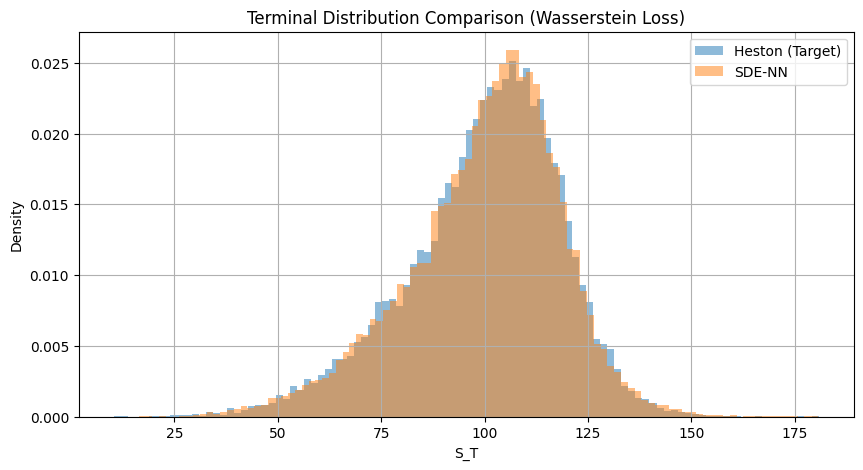

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define the SDE-NN with drift and volatility for both asset and volatility
class SDENN(nn.Module):
    def __init__(self):
        super().__init__()
        # Neural network with inputs (S_t, Y_t) and outputs for drift and volatility
        self.net = nn.Sequential(
            nn.Linear(2, 32),  # Input: [S_t, Y_t]
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 4)  # Output: [mu_S, log_sigma_S, mu_Y, log_sigma_Y]
        )

    def forward(self, x):
        return self.net(x)

# Function to compute the drift and volatility for both processes
def compute_drift_volatility(model, S_t, Y_t):
    # Neural network input: [S_t, Y_t]
    x = torch.cat([S_t, Y_t], dim=1)  # Concatenate S_t and Y_t
    output = model(x)

    mu_S = output[:, 0:1]  # Drift for asset price (S_t)
    log_sigma_S = output[:, 1:2]  # Log-volatility for asset price (S_t)
    mu_Y = output[:, 2:3]  # Drift for volatility (Y_t)
    log_sigma_Y = output[:, 3:4]  # Log-volatility for volatility (Y_t)

    sigma_S = torch.exp(log_sigma_S)
    sigma_Y = torch.exp(log_sigma_Y)

    return mu_S, sigma_S, mu_Y, sigma_Y

# Function to simulate the SDE using the SDENN model
def simulate_sdenn(S0, Y0, T, N, M, model, rho):
    dt = T / N
    S = torch.zeros(M, N + 1)
    Y = torch.zeros(M, N + 1)
    S[:, 0] = S0
    Y[:, 0] = Y0

    # Loop over time steps
    for t in range(N):
        S_t = S[:, t].unsqueeze(1).clone()  # Current asset prices (clone to avoid inplace modification)
        Y_t = Y[:, t].unsqueeze(1).clone()  # Current volatilities (clone to avoid inplace modification)

        mu_S, sigma_S, mu_Y, sigma_Y = compute_drift_volatility(model, S_t, Y_t)

        # Generate correlated Brownian motions
        Z1 = torch.randn(M, 1)
        Z2 = rho * Z1 + torch.sqrt(torch.tensor(1 - rho**2)) * torch.randn(M, 1)

        # Euler-Maruyama discretization
        dS = (mu_S * S_t * dt) + (sigma_S * torch.sqrt(torch.abs(Y_t)) * S_t * torch.sqrt(torch.tensor(dt)) * Z1)
        dY = (mu_Y * dt) + (sigma_Y * torch.sqrt(torch.abs(Y_t)) * torch.sqrt(torch.tensor(dt)) * Z2)

        S[:, t+1] = torch.relu(S_t + dS).squeeze(1)
        Y[:, t+1] = torch.relu(Y_t + dY).squeeze(1)

    return S, Y

# Heston Model Simulator (for generating target data)
def simulate_heston(S0, v0, r, kappa, theta, sigma, rho, T, N, M):
    dt = T / N
    S = torch.zeros(M, N + 1)
    v = torch.zeros(M, N + 1)
    S[:, 0] = S0
    v[:, 0] = v0

    for t in range(N):
        Z1 = torch.randn(M, 1)
        Z2 = rho * Z1 + torch.sqrt(torch.tensor(1 - rho**2)) * torch.randn(M, 1)
        v_t = torch.clamp(v[:, t].unsqueeze(1), min=0).clone() # Ensure non-negative variance and clone
        dv = (kappa * (theta - v_t) * dt) + (sigma * torch.sqrt(v_t) * torch.sqrt(torch.tensor(dt)) * Z2)
        dS = (r - 0.5 * v_t) * dt + torch.sqrt(v_t) * torch.sqrt(torch.tensor(dt)) * Z1
        v[:, t+1] = torch.relu((v_t + dv).squeeze(1)) # Ensure non-negative variance
        S[:, t+1] = (S[:, t].unsqueeze(1) * torch.exp(dS)).squeeze(1) # Ensure non-negative price
    return S, v

# Wasserstein Distance Loss
def wasserstein_loss(real, generated):
    real_sorted, _ = torch.sort(real, dim=0)
    gen_sorted, _ = torch.sort(generated, dim=0)
    return torch.mean(torch.abs(real_sorted - gen_sorted))

# Training the SDE-NN using Wasserstein Loss
def train_sdenn():
    model = SDENN()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # Parameters for the simulation (matching the target Heston model)
    S0_target = 100.0
    Y0_target = 0.04
    r_target = 0.0
    kappa_target = 2.0
    theta_target = 0.04
    sigma_target = 0.5
    rho_target = -0.7
    T = 1.0
    N = 100
    M = 20000  # Number of paths

    # Ground truth Heston paths
    S_heston_target, _ = simulate_heston(S0_target, Y0_target, r_target, kappa_target, theta_target, sigma_target, rho_target, T, N, M)
    S_heston_terminal_target = S_heston_target[:, -1].unsqueeze(1)

    for epoch in range(500): 
        # Generate paths using the SDENN model
        S_sdenn, _ = simulate_sdenn(S0_target, Y0_target, T, N, M, model, rho_target)
        S_sdenn_terminal = S_sdenn[:, -1].unsqueeze(1)

        # Compute the Wasserstein loss between true Heston and SDENN terminal paths
        loss = wasserstein_loss(S_heston_terminal_target, S_sdenn_terminal)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 1 == 0:
            print(f"Epoch {epoch}, Wasserstein Loss: {loss.item():.4f}")

    return model

# Example usage:
model = train_sdenn()

# Evaluate and visualize terminal distributions
with torch.no_grad():
    S0_eval = 100.0
    Y0_eval = 0.04
    T_eval = 1.0
    N_eval = 100
    M_eval = 20000
    rho_eval = -0.7
    S_sdenn_eval, _ = simulate_sdenn(S0_eval, Y0_eval, T_eval, N_eval, M_eval, model, rho_eval)
    S_sdenn_terminal_eval = S_sdenn_eval[:, -1].numpy()

    S_heston_eval, _ = simulate_heston(S0_eval, Y0_eval, 0.0, 2.0, 0.04, 0.5, rho_eval, T_eval, N_eval, M_eval)
    S_heston_terminal_eval = S_heston_eval[:, -1].numpy()

# Plot comparison
plt.figure(figsize=(10, 5))
plt.hist(S_heston_terminal_eval, bins=100, alpha=0.5, label="Heston (Target)", density=True)
plt.hist(S_sdenn_terminal_eval, bins=100, alpha=0.5, label="SDE-NN", density=True)
plt.legend()
plt.title("Terminal Distribution Comparison (Wasserstein Loss)")
plt.xlabel("S_T")
plt.ylabel("Density")
plt.grid(True)
plt.show()

Epoch 1/500
1/1 [==============================] - 28s 28s/step - loss: 4.4235
Epoch 2/500
1/1 [==============================] - 0s 437ms/step - loss: 4.2394
Epoch 3/500
1/1 [==============================] - 0s 403ms/step - loss: 3.8223
Epoch 4/500
1/1 [==============================] - 0s 447ms/step - loss: 3.7432
Epoch 5/500
1/1 [==============================] - 0s 435ms/step - loss: 3.5255
Epoch 6/500
1/1 [==============================] - 0s 378ms/step - loss: 3.2749
Epoch 7/500
1/1 [==============================] - 0s 435ms/step - loss: 3.1050
Epoch 8/500
1/1 [==============================] - 0s 436ms/step - loss: 2.9896
Epoch 9/500
1/1 [==============================] - 0s 500ms/step - loss: 2.5893
Epoch 10/500
1/1 [==============================] - 0s 460ms/step - loss: 2.6779
Epoch 11/500
1/1 [==============================] - 0s 469ms/step - loss: 2.6211
Epoch 12/500
1/1 [==============================] - 0s 484ms/step - loss: 2.5294
Epoch 13/500
1/1 [====================

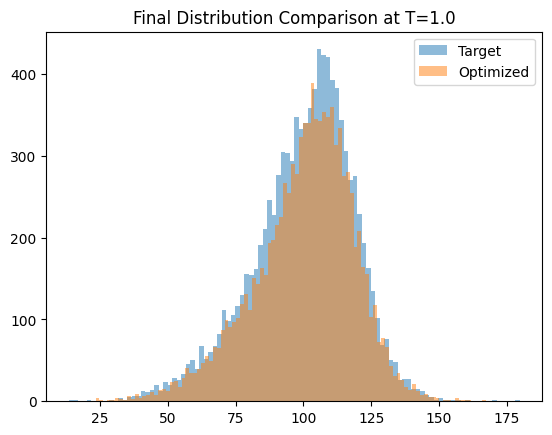

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance

# Constants
T = 1.0
N_STEPS = 100
dt = T / N_STEPS
N_PATHS = 10000

true_params = {
    "S0": 100.0,
    "v0": 0.04,
    "kappa": 2.0,
    "theta": 0.04,
    "sigma": 0.5,
    "rho": -0.7,
    "r": 0.0
}

def simulate_heston_tf(S0, v0, kappa, theta, sigma, rho, r, dt, n_steps, n_paths):
    z1 = tf.random.normal((n_paths, n_steps), dtype=tf.float32)
    z2 = tf.random.normal((n_paths, n_steps), dtype=tf.float32)
    dW1 = z1 * tf.sqrt(dt)
    dW2 = (rho * z1 + tf.sqrt(1 - rho**2) * z2) * tf.sqrt(dt)

    S = tf.ones((n_paths,), dtype=tf.float32) * S0
    v = tf.ones((n_paths,), dtype=tf.float32) * v0

    for t in range(n_steps):
        v = tf.maximum(v, 1e-6)
        sqrt_v = tf.sqrt(v)

        v = tf.nn.relu(v + kappa * (theta - v) * dt + sigma * sqrt_v * dW2[:, t])
        S = S * tf.exp((r - 0.5 * v) * dt + sqrt_v * dW1[:, t])
    return S


class HestonParameterModel(keras.Model):
    def __init__(self, S0, r):
        super().__init__()
        self.S0 = S0
        self.r = r

        self.v0 = tf.Variable(0.02, trainable=True, dtype=tf.float32, constraint=lambda x: tf.clip_by_value(x, 1e-5, 0.5))
        self.kappa = tf.Variable(1.0, trainable=True, dtype=tf.float32, constraint=lambda x: tf.clip_by_value(x, 0.01, 10.0))
        self.theta = tf.Variable(0.02, trainable=True, dtype=tf.float32, constraint=lambda x: tf.clip_by_value(x, 1e-5, 0.5))
        self.sigma = tf.Variable(0.3, trainable=True, dtype=tf.float32, constraint=lambda x: tf.clip_by_value(x, 0.01, 2.0))
        self.rho = tf.Variable(-0.3, trainable=True, dtype=tf.float32, constraint=lambda x: tf.clip_by_value(x, -0.99, 0.99))

    def call(self, inputs):
        # Simulate prices using the current parameters
        prices = simulate_heston_tf(
            self.S0, self.v0, self.kappa, self.theta,
            self.sigma, self.rho, self.r,
            dt=dt, n_steps=N_STEPS, n_paths=N_PATHS
        )
        return prices


# --- Target prices
target_prices = simulate_heston_tf(**true_params, dt=dt, n_steps=N_STEPS, n_paths=N_PATHS)

def wasserstein_loss(y_true, y_pred):
    y_true_sorted = tf.sort(y_true, axis=0)
    y_pred_sorted = tf.sort(y_pred, axis=0)
    return tf.reduce_mean(tf.abs(y_true_sorted - y_pred_sorted))

# --- Instantiate model
model = HestonParameterModel(S0=true_params["S0"], r=true_params["r"])

# --- Compile model
model.compile(optimizer=keras.optimizers.Adam(), loss=wasserstein_loss)

# --- Dummy input (unused)
dummy_input = tf.zeros((1,))  # no actual input used

# --- Keras training loop
class DistributionDataGenerator(keras.utils.Sequence):
    def __len__(self):
        return 1  # single batch
    def __getitem__(self, idx):
        return dummy_input, target_prices

dataset = DistributionDataGenerator()

# --- Train
model.fit(dataset, epochs=500)

# --- Final parameters
print("\nOptimized Parameters:")
print(f"v0: {model.v0.numpy():.4f} vs {true_params['v0']:.4f} (target)")
print(f"kappa: {model.kappa.numpy():.4f} vs {true_params['kappa']:.4f} (target)")
print(f"theta: {model.theta.numpy():.4f} vs {true_params['theta']:.4f} (target)")
print(f"sigma: {model.sigma.numpy():.4f} vs {true_params['sigma']:.4f} (target)")
print(f"rho: {model.rho.numpy():.4f} vs {true_params['rho']:.4f} (target)")

# --- Compare distributions
sim_prices_final = model(dummy_input).numpy()

plt.hist(target_prices.numpy(), bins=100, alpha=0.5, label="Target", density=True)
plt.hist(sim_prices_final, bins=100, alpha=0.5, label="Optimized", density=True)
plt.legend()
plt.title("Final Distribution Comparison at T=1.0")
plt.show()


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

tf.random.set_seed(42)
np.random.seed(42)

# ----- SDE-NN Model -----
class SDENN(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.net = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(2,)),
            tf.keras.layers.Dense(32, activation='tanh'),
            tf.keras.layers.Dense(32, activation='tanh'),
            tf.keras.layers.Dense(4)  # mu_S, log_sigma_S, mu_Y, log_sigma_Y
        ])

    def call(self, x):
        return self.net(x)

def compute_drift_volatility(model, S, Y):
    x = tf.concat([S, Y], axis=1)
    out = model(x)
    mu_S = out[:, :1]
    log_sigma_S = out[:, 1:2]
    mu_Y = out[:, 2:3]
    log_sigma_Y = out[:, 3:4]

    # Apply clipping to log_sigma to ensure sigma is not too extreme
    log_sigma_S = tf.clip_by_value(log_sigma_S, -5.0, 5.0) # Adjusted range
    log_sigma_Y = tf.clip_by_value(log_sigma_Y, -5.0, 5.0) # Adjusted range

    sigma_S = tf.exp(log_sigma_S)
    sigma_Y = tf.exp(log_sigma_Y)

    return mu_S, sigma_S, mu_Y, sigma_Y

# ----- SDE Simulation (Python loop, JIT compiled) -----
@tf.function
def simulate_sdenn(S0, Y0, T, N, M, model, rho):
    dt = tf.constant(T / N, tf.float32)
    S = tf.ones((M, 1), tf.float32) * S0
    Y = tf.ones((M, 1), tf.float32) * Y0

    for _ in tf.range(N):
        mu_S, sigma_S, mu_Y, sigma_Y = compute_drift_volatility(model, S, Y)
        
        # Clip S and Y before using them in calculations to prevent extreme values
        S = tf.clip_by_value(S, 1e-5, 1e5) # S must be positive and bounded
        Y = tf.clip_by_value(Y, 1e-5, 1e3) # Y must be positive and bounded

        # Further clipping for drift terms if they become too large
        mu_S = tf.clip_by_value(mu_S, -100.0, 100.0)
        mu_Y = tf.clip_by_value(mu_Y, -100.0, 100.0)

        Z1 = tf.random.normal((M, 1))
        Z2 = rho * Z1 + tf.sqrt(1. - rho**2) * tf.random.normal((M, 1))
        
        # Ensure Y is non-negative before sqrt
        sqrt_Y_S = tf.sqrt(tf.maximum(Y, 1e-9))
        sqrt_Y_Y = tf.sqrt(tf.maximum(Y, 1e-9))

        dS = mu_S * S * dt + sigma_S * sqrt_Y_S * S * tf.sqrt(dt) * Z1
        dY = mu_Y * dt + sigma_Y * sqrt_Y_Y * tf.sqrt(dt) * Z2
        
        # Apply relu and clipping more carefully after updates
        S = tf.nn.relu(S + dS)
        Y = tf.nn.relu(Y + dY)
        
        # Additional clipping for S and Y after the update step
        S = tf.clip_by_value(S, 1e-5, 1e5)
        Y = tf.clip_by_value(Y, 1e-5, 1e3)

    return S, Y

# ----- Heston Simulator -----
def simulate_heston(S0, v0, r, kappa, theta, sigma, rho, T, N, M):
    dt = T / N
    S = np.full((M, N + 1), S0, dtype=np.float32)
    v = np.full((M, N + 1), v0, dtype=np.float32)
    for t in range(N):
        Z1 = np.random.randn(M, 1)
        Z2 = rho * Z1 + np.sqrt(1 - rho**2) * np.random.randn(M, 1)
        v_t = np.clip(v[:, t:t+1], 0, None)
        dv = kappa * (theta - v_t) * dt + sigma * np.sqrt(v_t) * np.sqrt(dt) * Z2
        dS = (r - 0.5 * v_t) * dt + np.sqrt(v_t) * np.sqrt(dt) * Z1
        v[:, t+1] = np.clip(v_t + dv, 0, None).flatten()
        S[:, t+1] = S[:, t] * np.exp(dS).flatten()
    return tf.convert_to_tensor(S, tf.float32), tf.convert_to_tensor(v, tf.float32)

# ----- Wasserstein Loss -----
@tf.function
def wasserstein_loss(real, generated):
    real_sorted = tf.sort(real, axis=0)
    gen_sorted = tf.sort(generated, axis=0)
    return tf.reduce_mean(tf.abs(real_sorted - gen_sorted))

# ----- Training -----
def train_sdenn():
    model = SDENN()
    optimizer = tf.keras.optimizers.Adam(1e-4) # Reduced learning rate

    # Target Heston Parameters
    S0, Y0 = 100.0, 0.04
    r, kappa, theta, sigma, rho = 0.0, 2.0, 0.04, 0.5, -0.7
    T, N, M = 1.0, 100, 5000

    # Pre-generate Heston terminal prices
    S_heston, _ = simulate_heston(S0, Y0, r, kappa, theta, sigma, rho, T, N, M)
    S_heston_terminal = tf.reshape(S_heston[:, -1], (-1, 1))

    for epoch in range(500):
        with tf.GradientTape() as tape:
            S_sdenn, _ = simulate_sdenn(S0, Y0, T, N, M, model, rho)
            # Ensure generated S_sdenn is also shaped for the loss function
            loss = wasserstein_loss(S_heston_terminal, S_sdenn)
        grads = tape.gradient(loss, model.trainable_variables)
        grads, _ = tf.clip_by_global_norm(grads, 1.0) # Gradient clipping
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        print(f"Epoch {epoch}, Wasserstein Loss: {loss.numpy():.4f}")

    return model

# ----- Run Training -----
model = train_sdenn()

# ----- Evaluation -----
S0_eval, Y0_eval, T_eval, N_eval, M_eval, rho_eval = 100.0, 0.04, 1.0, 100, 20000, -0.7
S_sdenn_eval, _ = simulate_sdenn(S0_eval, Y0_eval, T_eval, N_eval, M_eval, model, rho_eval)
S_heston_eval, _ = simulate_heston(S0_eval, Y0_eval, 0.0, 2.0, 0.04, 0.5, rho_eval, T_eval, N_eval, M_eval)

plt.figure(figsize=(10, 5))
plt.hist(S_heston_eval[:, -1].numpy(), bins=100, alpha=0.5, label="Heston (Target)", density=True)
plt.hist(S_sdenn_eval.numpy(), bins=100, alpha=0.5, label="SDE-NN", density=True)
plt.legend()
plt.title("Terminal Distribution Comparison (Wasserstein Loss)")
plt.xlabel("$S_T$")
plt.ylabel("Density")
plt.grid(True)
plt.show()

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time # Import time for benchmarking

tf.random.set_seed(42)
np.random.seed(42)

# ----- SDE-NN Model -----
class SDENN(tf.keras.Model):
    def __init__(self, S0, Y0, T, N, M, rho):
        super().__init__()
        self.net = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(2,)),
            tf.keras.layers.Dense(32, activation='tanh'),
            tf.keras.layers.Dense(32, activation='tanh'),
            tf.keras.layers.Dense(4)  # mu_S, log_sigma_S, mu_Y, log_sigma_Y
        ])
        # Store SDE parameters as non-trainable TensorFlow constants for graph optimization
        self.S0 = tf.constant(S0, dtype=tf.float32)
        self.Y0 = tf.constant(Y0, dtype=tf.float32)
        self.T = tf.constant(T, dtype=tf.float32)
        self.N = tf.constant(N, dtype=tf.int32) # N should be int for tf.range
        self.M = tf.constant(M, dtype=tf.int32) # M should be int for shape
        self.rho = tf.constant(rho, dtype=tf.float32)
        self.dt = self.T / tf.cast(self.N, tf.float32) # Pre-calculate dt

    # @tf.function is moved to train_step for better control over tracing
    def compute_drift_volatility(self, S, Y):
        x = tf.concat([S, Y], axis=1)
        out = self.net(x)
        mu_S = out[:, :1]
        log_sigma_S = out[:, 1:2]
        mu_Y = out[:, 2:3]
        log_sigma_Y = out[:, 3:4]

        log_sigma_S = tf.clip_by_value(log_sigma_S, -5.0, 5.0)
        log_sigma_Y = tf.clip_by_value(log_sigma_Y, -5.0, 5.0)

        sigma_S = tf.exp(log_sigma_S)
        sigma_Y = tf.exp(log_sigma_Y)

        return mu_S, sigma_S, mu_Y, sigma_Y

    # @tf.function should be applied to train_step, not necessarily simulate_sdenn
    # as simulate_sdenn is called within train_step which is already decorated.
    # Marking simulate_sdenn itself with @tf.function can lead to retracing if
    # instance attributes (like self.net weights) change, which they do during training.
    # The current structure effectively puts simulate_sdenn into the train_step graph.
    def simulate_sdenn(self):
        S = tf.ones((self.M, 1), tf.float32) * self.S0
        Y = tf.ones((self.M, 1), tf.float32) * self.Y0

        for _ in tf.range(self.N): # Use tf.range for graph compatibility
            mu_S, sigma_S, mu_Y, sigma_Y = self.compute_drift_volatility(S, Y)
            
            # Clipping before using them in calculations
            S = tf.clip_by_value(S, 1e-5, 1e5)
            Y = tf.clip_by_value(Y, 1e-5, 1e3)

            # Further clipping for drift terms
            mu_S = tf.clip_by_value(mu_S, -100.0, 100.0)
            mu_Y = tf.clip_by_value(mu_Y, -100.0, 100.0)

            Z1 = tf.random.normal((self.M, 1))
            Z2 = self.rho * Z1 + tf.sqrt(1. - self.rho**2) * tf.random.normal((self.M, 1))
            
            # Ensure Y is non-negative before sqrt
            sqrt_Y_S = tf.sqrt(tf.maximum(Y, 1e-9))
            sqrt_Y_Y = tf.sqrt(tf.maximum(Y, 1e-9))

            dS = mu_S * S * self.dt + sigma_S * sqrt_Y_S * S * tf.sqrt(self.dt) * Z1
            dY = mu_Y * self.dt + sigma_Y * sqrt_Y_Y * tf.sqrt(self.dt) * Z2
            
            S = tf.nn.relu(S + dS)
            Y = tf.nn.relu(Y + dY)
            
            # Additional clipping for S and Y after the update step
            S = tf.clip_by_value(S, 1e-5, 1e5)
            Y = tf.clip_by_value(Y, 1e-5, 1e3)
        return S # Return only the terminal S values for loss calculation

    @tf.function
    def train_step(self, data):
        # `data` will be the `(S_heston_terminal,)` tuple passed by fit()
        S_heston_terminal = data[0]

        with tf.GradientTape() as tape:
            S_sdenn_terminal = self.simulate_sdenn() # Call the simulation within the tape
            loss = self.compiled_loss(S_heston_terminal, S_sdenn_terminal)

        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        gradients, _ = tf.clip_by_global_norm(gradients, 1.0) # Gradient clipping
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        return {"loss": loss}

    @tf.function
    def test_step(self, data):
        S_heston_terminal = data[0]
        S_sdenn_terminal = self.simulate_sdenn()
        loss = self.compiled_loss(S_heston_terminal, S_sdenn_terminal)
        return {"loss": loss}

# ----- Heston Simulator -----
def simulate_heston(S0, v0, r, kappa, theta, sigma, rho, T, N, M):
    dt = T / N
    S = np.full((M, N + 1), S0, dtype=np.float32)
    v = np.full((M, N + 1), v0, dtype=np.float32)
    for t in range(N):
        Z1 = np.random.randn(M, 1)
        Z2 = rho * Z1 + np.sqrt(1 - rho**2) * np.random.randn(M, 1)
        v_t = np.clip(v[:, t:t+1], 0, None)
        dv = kappa * (theta - v_t) * dt + sigma * np.sqrt(v_t) * np.sqrt(dt) * Z2
        dS = (r - 0.5 * v_t) * dt + np.sqrt(v_t) * np.sqrt(dt) * Z1
        v[:, t+1] = np.clip(v_t + dv, 0, None).flatten()
        S[:, t+1] = S[:, t] * np.exp(dS).flatten()
    return tf.convert_to_tensor(S, tf.float32), tf.convert_to_tensor(v, tf.float32)

# ----- Wasserstein Loss -----
class WassersteinLoss(tf.keras.losses.Loss):
    def __init__(self, name="wasserstein_loss"):
        super().__init__(name=name)

    @tf.function
    def call(self, y_true, y_pred):
        real_sorted = tf.sort(y_true, axis=0)
        gen_sorted = tf.sort(y_pred, axis=0)
        return tf.reduce_mean(tf.abs(real_sorted - gen_sorted))

# ----- Training -----
# Define Heston parameters
S0, Y0 = 100.0, 0.04
r, kappa, theta, sigma, rho = 0.0, 2.0, 0.04, 0.5, -0.7
T, N, M_train = 1.0, 100, 5000 # M_train for training batch size

# Instantiate the custom model
model = SDENN(S0=S0, Y0=Y0, T=T, N=N, M=M_train, rho=rho)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=WassersteinLoss())

# Pre-generate Heston terminal prices for training
S_heston_train, _ = simulate_heston(S0, Y0, r, kappa, theta, sigma, rho, T, N, M_train)
S_heston_terminal_train = tf.reshape(S_heston_train[:, -1], (-1, 1))

print("Starting training...")
start_time = time.time()

history = model.fit(x=S_heston_terminal_train, y=S_heston_terminal_train,
                    epochs=200,
                    batch_size=M_train,
                    verbose=1)

end_time = time.time()
print(f"Training finished in {end_time - start_time:.2f} seconds.")
print(history.history)

# ----- Evaluation -----
S0_eval, Y0_eval, T_eval, N_eval, M_eval, rho_eval = 100.0, 0.04, 1.0, 100, 20000, -0.7

# To reuse the model for evaluation with different parameters, update its internal constants
# Or, if these parameters are dynamic, consider making simulate_sdenn accept them directly
# rather than relying on instance attributes. For now, updating attributes is simple.
model.S0 = tf.constant(S0_eval, dtype=tf.float32)
model.Y0 = tf.constant(Y0_eval, dtype=tf.float32)
model.T = tf.constant(T_eval, dtype=tf.float32)
model.N = tf.constant(N_eval, dtype=tf.int32)
model.M = tf.constant(M_eval, dtype=tf.int32)
model.rho = tf.constant(rho_eval, dtype=tf.float32)
model.dt = model.T / tf.cast(model.N, tf.float32) # Recalculate dt

S_sdenn_eval = model.simulate_sdenn() # Now calls the updated model
S_heston_eval, _ = simulate_heston(S0_eval, Y0_eval, 0.0, 2.0, 0.04, 0.5, rho_eval, T_eval, N_eval, M_eval)

plt.figure(figsize=(10, 5))
plt.hist(S_heston_eval[:, -1].numpy(), bins=100, alpha=0.5, label="Heston (Target)", density=True)
plt.hist(S_sdenn_eval.numpy(), bins=100, alpha=0.5, label="SDE-NN", density=True)
plt.legend()
plt.title("Terminal Distribution Comparison (Wasserstein Loss)")
plt.xlabel("$S_T$")
plt.ylabel("Density")
plt.grid(True)
plt.show()

Con loss para diferentes Ts

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time # Import time for benchmarking

tf.random.set_seed(42)
np.random.seed(42)

# ----- SDE-NN Model -----
class SDENN(tf.keras.Model):
    def __init__(self, S0, Y0, T, N, M_initial, rho): # M_initial is now just for initial setup
        super().__init__()
        self.net = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(2,)),
            tf.keras.layers.Dense(32, activation='tanh'),
            tf.keras.layers.Dense(32, activation='tanh'),
            tf.keras.layers.Dense(4)  # mu_S, log_sigma_S, mu_Y, log_sigma_Y
        ])
        # Store SDE parameters as non-trainable TensorFlow constants for graph optimization
        self.S0 = tf.constant(S0, dtype=tf.float32)
        self.Y0 = tf.constant(Y0, dtype=tf.float32)
        self.T = tf.constant(T, dtype=tf.float32)
        self.N = tf.constant(N, dtype=tf.int32) # N should be int for tf.range
        # self.M is no longer a fixed attribute for simulation batch size
        self.rho = tf.constant(rho, dtype=tf.float32)
        self.dt = self.T / tf.cast(self.N, tf.float32) # Pre-calculate dt

    def compute_drift_volatility(self, S, Y):
        """
        Computes the drift and volatility terms for S and Y using the neural network.

        Args:
            S (tf.Tensor): Current stock prices (batch_size, 1).
            Y (tf.Tensor): Current variance values (batch_size, 1).

        Returns:
            tuple: (mu_S, sigma_S, mu_Y, sigma_Y) as TensorFlow tensors.
        """
        x = tf.concat([S, Y], axis=1)
        out = self.net(x)
        mu_S = out[:, :1]
        log_sigma_S = out[:, 1:2]
        mu_Y = out[:, 2:3]
        log_sigma_Y = out[:, 3:4]

        # Clip log_sigma to prevent extremely large or small volatilities
        log_sigma_S = tf.clip_by_value(log_sigma_S, -5.0, 5.0)
        log_sigma_Y = tf.clip_by_value(log_sigma_Y, -5.0, 5.0)

        sigma_S = tf.exp(log_sigma_S)
        sigma_Y = tf.exp(log_sigma_Y)

        return mu_S, sigma_S, mu_Y, sigma_Y

    def simulate_sdenn(self, num_paths): # Accepts num_paths (batch size)
        """
        Simulates paths for the SDE-NN model over N time steps.
        Stores and returns the stock price S at each time step.

        Args:
            num_paths (tf.Tensor or int): The number of paths (batch size) to simulate.

        Returns:
            tf.Tensor: Simulated stock prices S at each time step, shape (num_paths, N).
        """
        S = tf.ones((num_paths, 1), tf.float32) * self.S0
        Y = tf.ones((num_paths, 1), tf.float32) * self.Y0

        # Tensor to store S at each time step.
        # We store N time steps, excluding the initial S0.
        S_paths = tf.TensorArray(tf.float32, size=self.N, dynamic_size=False, clear_after_read=False)

        for i in tf.range(self.N): # Use tf.range for graph compatibility
            mu_S, sigma_S, mu_Y, sigma_Y = self.compute_drift_volatility(S, Y)
            
            # Clipping before using them in calculations to maintain numerical stability
            S = tf.clip_by_value(S, 1e-5, 1e5)
            Y = tf.clip_by_value(Y, 1e-5, 1e3)

            # Further clipping for drift terms
            mu_S = tf.clip_by_value(mu_S, -100.0, 100.0)
            mu_Y = tf.clip_by_value(mu_Y, -100.0, 100.0)

            Z1 = tf.random.normal((num_paths, 1)) # Use num_paths
            Z2 = self.rho * Z1 + tf.sqrt(1. - self.rho**2) * tf.random.normal((num_paths, 1)) # Use num_paths
            
            # Ensure Y is non-negative before sqrt to avoid NaNs
            sqrt_Y_S = tf.sqrt(tf.maximum(Y, 1e-9))
            sqrt_Y_Y = tf.sqrt(tf.maximum(Y, 1e-9))

            dS = mu_S * S * self.dt + sigma_S * sqrt_Y_S * S * tf.sqrt(self.dt) * Z1
            dY = mu_Y * self.dt + sigma_Y * sqrt_Y_Y * tf.sqrt(self.dt) * Z2
            
            # Apply ReLU to ensure S and Y remain non-negative
            S = tf.nn.relu(S + dS)
            Y = tf.nn.relu(Y + dY)
            
            # Additional clipping for S and Y after the update step
            S = tf.clip_by_value(S, 1e-5, 1e5)
            Y = tf.clip_by_value(Y, 1e-5, 1e3)

            # Write the current S distribution to the TensorArray
            S_paths = S_paths.write(i, S)
        
        # Stack the TensorArray into a single tensor of shape (N, num_paths, 1) and then reshape to (num_paths, N)
        return tf.transpose(tf.squeeze(S_paths.stack(), axis=-1)) # Shape (num_paths, N)

    @tf.function
    def train_step(self, data):
        S_heston_paths = data[0]
        current_batch_size = tf.shape(S_heston_paths)[0] # Get current batch size from input data

        with tf.GradientTape() as tape:
            S_sdenn_paths = self.simulate_sdenn(current_batch_size) # Pass batch size
            loss = self.compiled_loss(S_heston_paths, S_sdenn_paths)

        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        gradients, _ = tf.clip_by_global_norm(gradients, 1.0) # Gradient clipping
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        return {"loss": loss}

    @tf.function
    def test_step(self, data):
        S_heston_paths = data[0]
        current_batch_size = tf.shape(S_heston_paths)[0] # Get current batch size from input data
        S_sdenn_paths = self.simulate_sdenn(current_batch_size) # Pass batch size
        loss = self.compiled_loss(S_heston_paths, S_sdenn_paths)
        return {"loss": loss}

# ----- Heston Simulator -----
def simulate_heston(S0, v0, r, kappa, theta, sigma, rho, T, N, M):
    """
    Simulates paths for the Heston model.

    Args:
        S0 (float): Initial stock price.
        v0 (float): Initial variance.
        r (float): Risk-free rate.
        kappa (float): Rate of mean reversion for variance.
        theta (float): Long-term mean variance.
        sigma (float): Volatility of volatility.
        rho (float): Correlation between stock and variance Wiener processes.
        T (float): Total time.
        N (int): Number of time steps.
        M (int): Number of paths.

    Returns:
        tuple: (S_paths, v_paths) as TensorFlow tensors, both of shape (M, N+1).
    """
    dt = T / N
    S = np.full((M, N + 1), S0, dtype=np.float32)
    v = np.full((M, N + 1), v0, dtype=np.float32)
    for t in range(N):
        Z1 = np.random.randn(M, 1)
        Z2 = rho * Z1 + np.sqrt(1 - rho**2) * np.random.randn(M, 1)
        v_t = np.clip(v[:, t:t+1], 0, None) # Ensure variance is non-negative
        dv = kappa * (theta - v_t) * dt + sigma * np.sqrt(v_t) * np.sqrt(dt) * Z2
        dS = (r - 0.5 * v_t) * dt + np.sqrt(v_t) * np.sqrt(dt) * Z1
        v[:, t+1] = np.clip(v_t + dv, 0, None).flatten()
        S[:, t+1] = S[:, t] * np.exp(dS).flatten()
    return tf.convert_to_tensor(S, tf.float32), tf.convert_to_tensor(v, tf.float32)

# ----- Wasserstein Loss -----
class WassersteinLoss(tf.keras.losses.Loss):
    def __init__(self, name="wasserstein_loss"):
        super().__init__(name=name)

    @tf.function
    def call(self, y_true, y_pred):
        """
        Calculates the average Wasserstein-1 distance between distributions at each time step.

        Args:
            y_true (tf.Tensor): Target distributions, shape (M, N_time_points).
            y_pred (tf.Tensor): Predicted distributions, shape (M, N_time_points).

        Returns:
            tf.Tensor: Scalar loss value.
        """
        # Ensure y_true and y_pred have the same shape
        tf.Assert(tf.equal(tf.shape(y_true), tf.shape(y_pred)), ["Shapes of y_true and y_pred must match"])

        num_time_points = tf.shape(y_true)[1]
        
        # Use a TensorArray to store loss for each time point
        losses_per_time_point = tf.TensorArray(tf.float32, size=num_time_points, dynamic_size=False)

        for i in tf.range(num_time_points):
            # Extract distributions for the current time point
            real_dist = y_true[:, i]
            gen_dist = y_pred[:, i]

            # Sort the distributions for Wasserstein distance calculation
            real_sorted = tf.sort(real_dist)
            gen_sorted = tf.sort(gen_dist)
            
            # Calculate L1 distance (Wasserstein-1 for 1D distributions)
            loss_i = tf.reduce_mean(tf.abs(real_sorted - gen_sorted))
            losses_per_time_point = losses_per_time_point.write(i, loss_i)
        
        # Average the losses across all time points
        return tf.reduce_mean(losses_per_time_point.stack())

# ----- Training -----
# Define Heston parameters
S0, Y0 = 100.0, 0.04
r, kappa, theta, sigma, rho = 0.0, 2.0, 0.04, 0.5, -0.7
T, N, M_train = 1.0, 100, 5000 # M_train for training batch size

# Instantiate the custom model
# Pass M_train as M_initial, but it won't be used for batching in simulate_sdenn
model = SDENN(S0=S0, Y0=Y0, T=T, N=N, M_initial=M_train, rho=rho)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=WassersteinLoss())

# Pre-generate Heston full paths for training
S_heston_train, _ = simulate_heston(S0, Y0, r, kappa, theta, sigma, rho, T, N, M_train)

# Use S_heston_train[:, 1:] to get distributions from t=dt to t=T (N columns)
S_heston_paths_target = S_heston_train[:, 1:] 

print("Starting training...")
start_time = time.time()

# Pass the full paths as x and y for training
history = model.fit(x=S_heston_paths_target, y=S_heston_paths_target,
                    epochs=1000,
                    batch_size=M_train, # Ensure batch_size matches M_train for training
                    verbose=1)

end_time = time.time()
print(f"Training finished in {end_time - start_time:.2f} seconds.")

# ----- Evaluation -----
S0_eval, Y0_eval, T_eval, N_eval, M_eval, rho_eval = 100.0, 0.04, 1.0, 100, 20000, -0.7

# No need to update model.M directly anymore as simulate_sdenn takes it as an argument
model.S0 = tf.constant(S0_eval, dtype=tf.float32)
model.Y0 = tf.constant(Y0_eval, dtype=tf.float32)
model.T = tf.constant(T_eval, dtype=tf.float32)
model.N = tf.constant(N_eval, dtype=tf.int32)
model.rho = tf.constant(rho_eval, dtype=tf.float32)
model.dt = model.T / tf.cast(model.N, tf.float32) # Recalculate dt

# Simulate Heston paths for evaluation
S_heston_eval_paths, _ = simulate_heston(S0_eval, Y0_eval, 0.0, 2.0, 0.04, 0.5, rho_eval, T_eval, N_eval, M_eval)
S_heston_eval_paths_target = S_heston_eval_paths[:, 1:] # Shape (M_eval, N_eval)

# Calculate and print the final evaluation loss
# IMPORTANT: Pass batch_size=M_eval to ensure the entire dataset is processed as one batch
# This makes y_true in test_step have shape (M_eval, N_eval), matching simulate_sdenn(M_eval)
final_eval_loss = model.evaluate(x=S_heston_eval_paths_target, y=S_heston_eval_paths_target,
                                 batch_size=M_eval, # Explicitly set batch_size for evaluation
                                 verbose=0)
print(f"Final evaluation loss: {final_eval_loss}")


# ----- Plotting Terminal Distributions -----
plt.figure(figsize=(10, 5))
# For plotting, we can simulate SDE-NN with M_eval paths directly for comparison
S_sdenn_eval_paths_for_plot = model.simulate_sdenn(M_eval) # Simulate with M_eval paths for plotting

plt.hist(S_heston_eval_paths_target[:, -1].numpy(), bins=100, alpha=0.5, label="Heston (Target, Terminal)", density=True)
plt.hist(S_sdenn_eval_paths_for_plot[:, -1].numpy(), bins=100, alpha=0.5, label="SDE-NN (Terminal)", density=True)
plt.legend()
plt.title(f"Terminal Distribution Comparison (Wasserstein Loss) at T={T_eval:.2f}")
plt.xlabel("$S_T$")
plt.ylabel("Density")
plt.grid(True)
plt.show()

# ----- Plotting Distribution at an Intermediate Time Step (e.g., T/2) -----
intermediate_time_step_idx = N_eval // 2 # Index for T/2
plt.figure(figsize=(10, 5))
plt.hist(S_heston_eval_paths_target[:, intermediate_time_step_idx].numpy(), bins=100, alpha=0.5, label=f"Heston (Target, T={intermediate_time_step_idx*T_eval/N_eval:.2f})", density=True)
plt.hist(S_sdenn_eval_paths_for_plot[:, intermediate_time_step_idx].numpy(), bins=100, alpha=0.5, label=f"SDE-NN (T={intermediate_time_step_idx*T_eval/N_eval:.2f})", density=True)
plt.legend()
plt.title(f"Distribution Comparison at T={intermediate_time_step_idx*T_eval/N_eval:.2f}")
plt.xlabel("$S_t$")
plt.ylabel("Density")
plt.grid(True)
plt.show()